In [1]:
import numpy as np
from numpy.random import normal
import pandas as pd
from copy import deepcopy as copy

import seaborn as sns
sns.set(color_codes=True)
from sklearn.decomposition import KernelPCA, PCA

from matplotlib import pyplot as plt


import torch 
from torch import nn, optim
import pandas as pd

from sklearn.manifold import Isomap

In [27]:
from sklearn.datasets import make_blobs

n_features = 2
n_hidden = 5
n_labels = 5
n_samples = 500

X, Y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_labels, cluster_std=0.5)
X, Y = X, Y

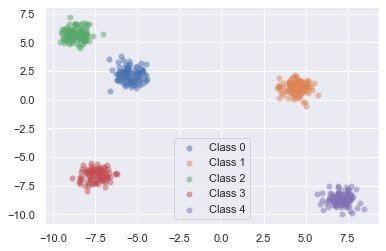

In [28]:
for i in range(n_labels):
    idx = Y == i
    sns.scatterplot(X[idx,0], X[idx,1], label='Class {}'.format(i), linewidth=0, alpha=0.5)
plt.legend()
plt.show()

In [34]:
class MLP(nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        self.fc_1 = nn.Linear(n_features, n_hidden, bias=True)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=0.5)
        self.fc_2 = nn.Linear(n_hidden, n_labels)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        output = self.fc_1(x)
        output = self.tanh(output)
        #output = self.dropout(output)
        output = self.fc_2(output)
        output = self.softmax(output)
        
        return output
    
    """
        Utility functions to take average of models
    """
    
    def __add__(self, other):
        my_copy = copy(self)
        with torch.no_grad():
            for self_param, other_param in zip(my_copy.parameters(), other.parameters()):
                self_param.data += other_param.data
        return my_copy
    
    def __truediv__(self, n):
        my_copy = copy(self)
        with torch.no_grad():
            for self_param in my_copy.parameters():
                self_param.data /= n
        return my_copy
    
    def zero(self):
        for self_param in self.parameters():
            self_param.data = torch.zeros_like(self_param.data)
        return self

In [158]:
n_model_params = sum([param.reshape(-1).shape[0] for param in MLP().parameters()])

In [29]:
n_clients = 10
class_p_client = 5

clusters = np.random.choice(range(n_labels), (n_clients, class_p_client))
label_idx = np.zeros((n_labels, n_samples//n_labels))
for i in range(n_labels):
    label_idx[i,:] = np.argwhere(Y == i).reshape(-1)
client_idx = label_idx[clusters,:].reshape(n_clients, -1).astype(int)

client_features = torch.tensor(X[client_idx]).float()
client_labels = torch.tensor(Y[client_idx])

In [30]:
df = pd.DataFrame(columns = ['client', 'feature_1', 'feature_2', 'label'])
df['client'] = [i for i in range(n_clients) for _ in range(int(n_samples/ n_labels) * class_p_client)]
df['feature_1'] = client_features[:, :, 0].reshape(-1)
df['feature_2'] = client_features[:, :, 1].reshape(-1)
df['label'] = client_labels.reshape(-1)

In [56]:
predictions = []
for data, model in zip(client_features, final_models):
    predictions.append(torch.argmax(model(data),axis=1).detach().numpy())

In [57]:
df['label_pred'] = np.concatenate(predictions)

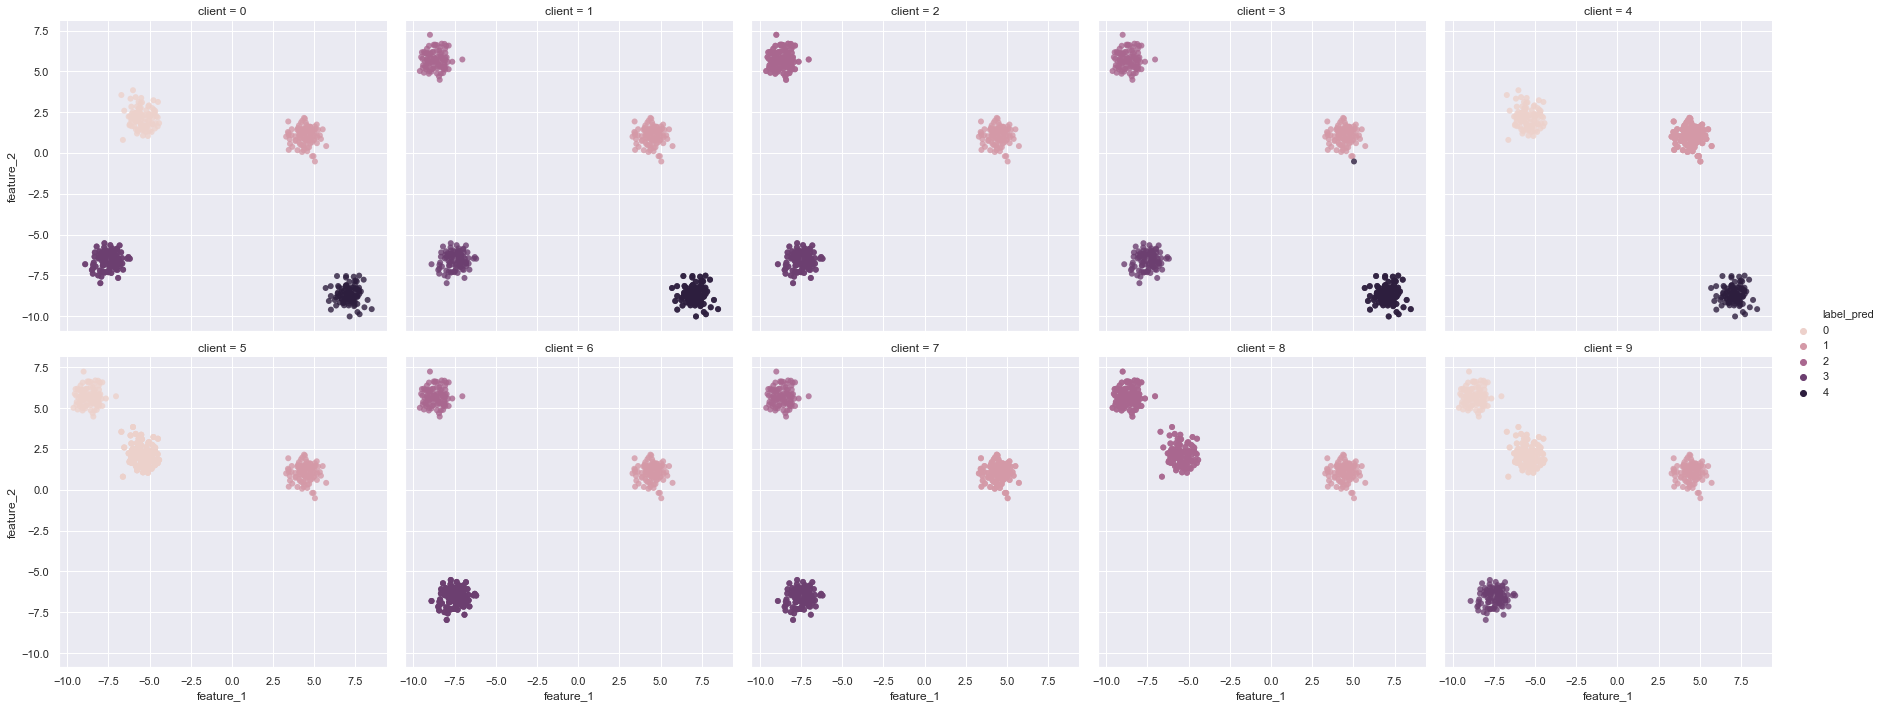

In [58]:
sns.relplot(x="feature_1", y="feature_2", hue="label_pred", col="client", data=df, col_wrap=5, alpha=0.8, linewidth=0,legend='full')
plt.show()

In [36]:
loss_fn = nn.NLLLoss()
batch_size = 200
n_steps = 250
lr = 0.01

In [37]:
all_steps = [[[] for _ in range(n_steps)] for _ in range(n_clients)]
losses = [[] for _ in range(n_clients)]
acc = [[] for _ in range(n_clients)]

final_models = []

for client in range(n_clients):
    model = MLP()
    optimizer = optim.Adam(lr=lr, params=model.parameters(), weight_decay=0.1)
    for step in range(n_steps):
        # log model state
        for name, param in model.named_parameters():
            all_steps[client][step].extend(list(param.view(-1).detach().numpy()))
        # take a step of SGD
        optimizer.zero_grad()
        batch_idx = np.random.randint(0, int(n_samples/ n_labels) * class_p_client, batch_size)
        predict = model(client_features[client, batch_idx])
        loss = loss_fn(predict, client_labels[client, batch_idx])
        loss.backward()
        optimizer.step()
        losses[client].append(loss.item())
        acc[client].append(sum(torch.argmax(predict, dim=1) == client_labels[client, batch_idx]))
    final_models.append(model)

In [12]:
step_matrix = torch.tensor(all_steps).reshape(-1, n_model_params)

In [13]:
pca = PCA(n_components=2)

x = pca.fit_transform(step_matrix)

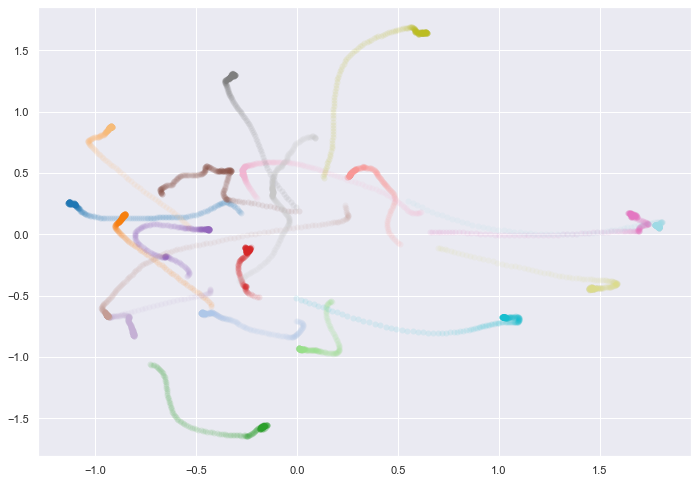

In [14]:
for i, color in zip(range(n_clients), (plt.get_cmap('tab20').colors * 10)[:n_clients]):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.scatterplot(x[i*n_steps:(i+1)*n_steps,0], x[i*n_steps:(i+1)*n_steps,1],alpha=0.1,color=color, linewidth=0)
#plt.legend()
plt.show()

In [15]:
runs = pd.DataFrame(columns = ['client', 'step', 'loss', 'accuracy'])
runs['client'] = [i for i in range(n_clients) for _ in range(n_steps)]
runs['step'] = list(range(n_steps)) * n_clients
runs['loss'] = np.array(losses).reshape(-1)
runs['accuracy'] = np.array(acc).reshape(-1) / batch_size * 100

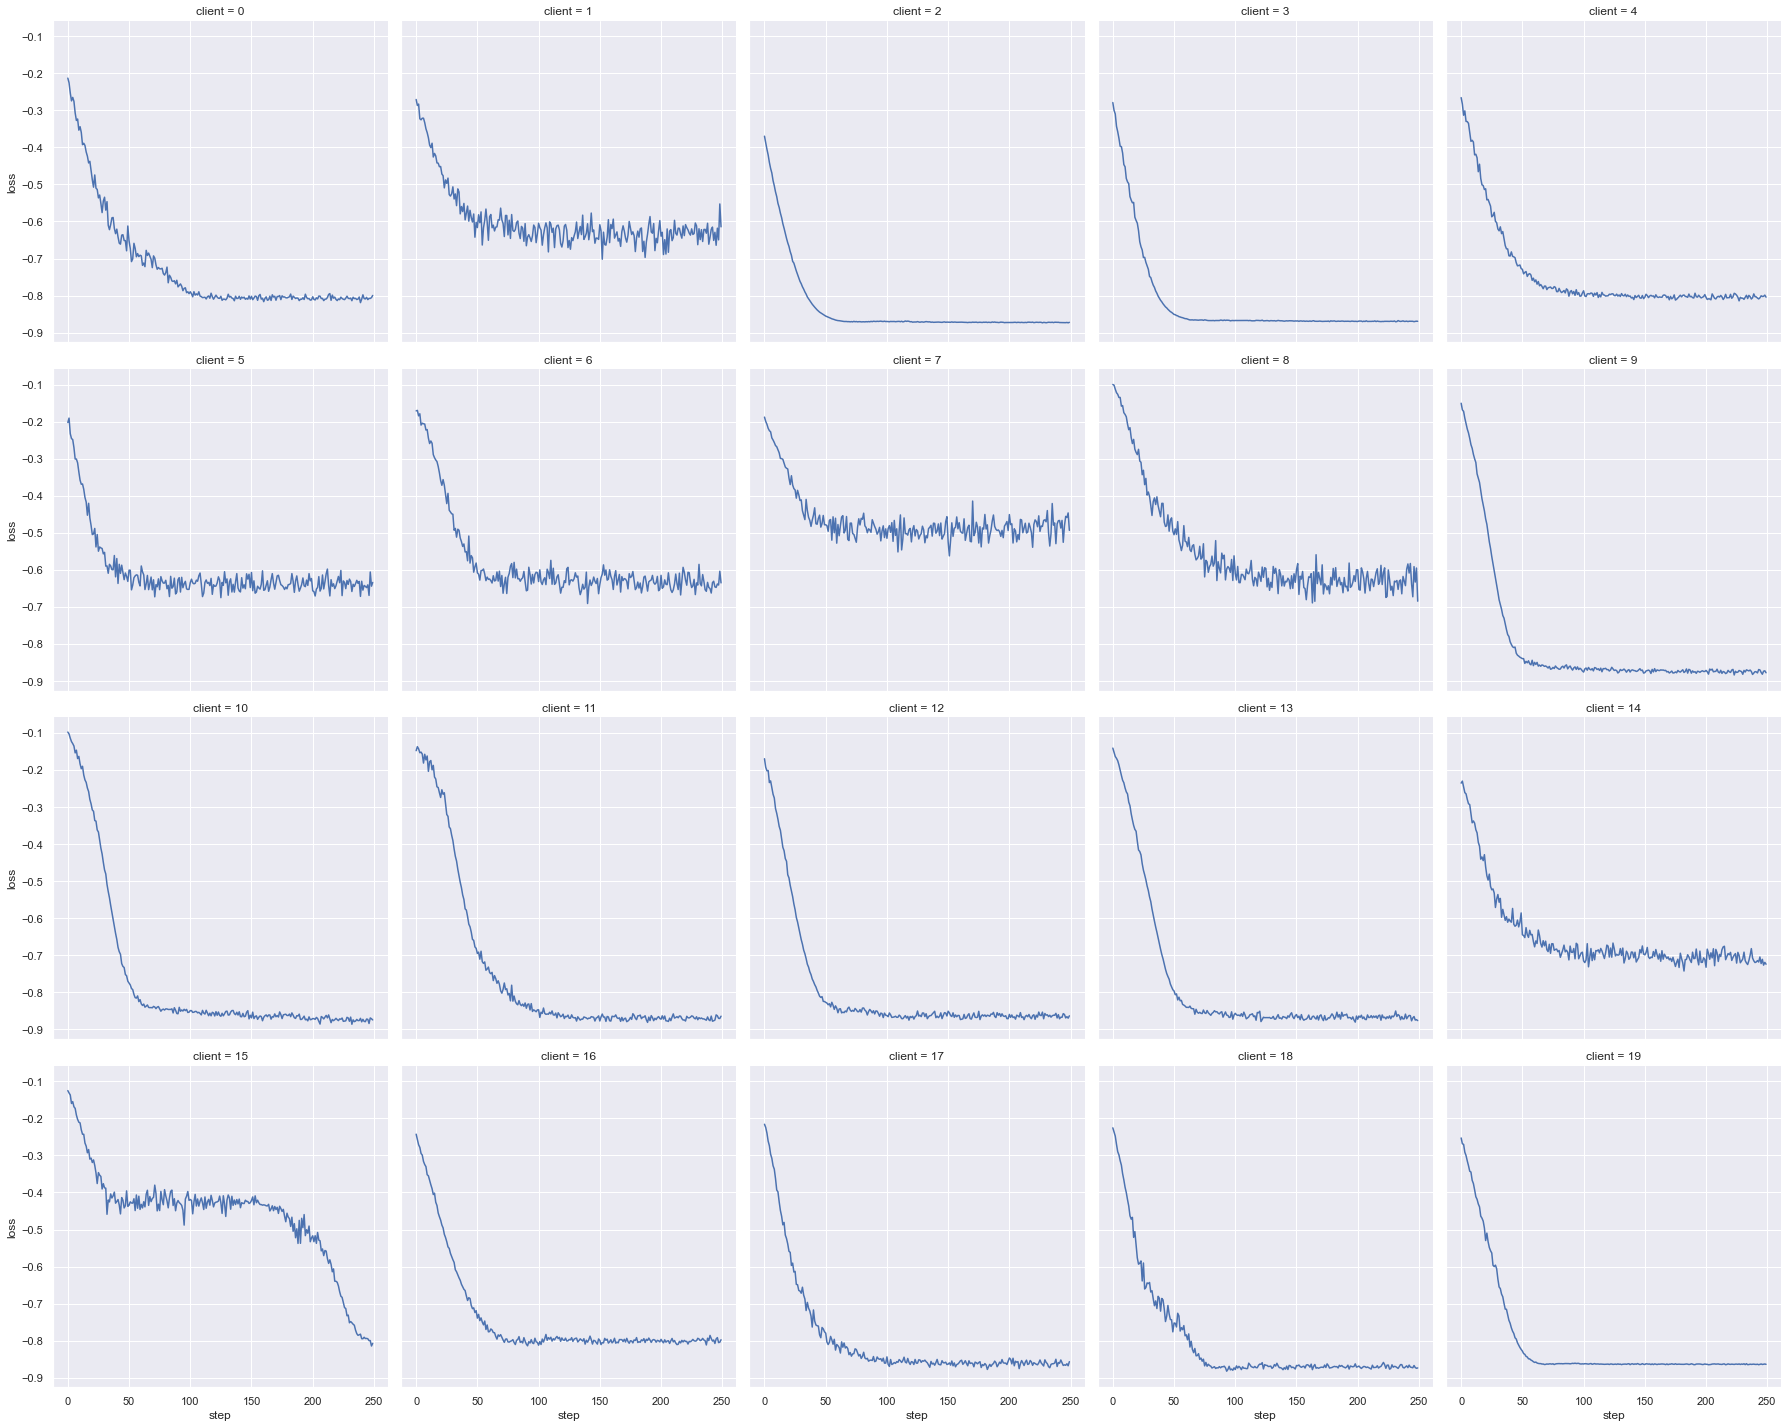

In [16]:
sns.relplot(x="step", y="loss", col="client", kind="line", data=runs, col_wrap=5)

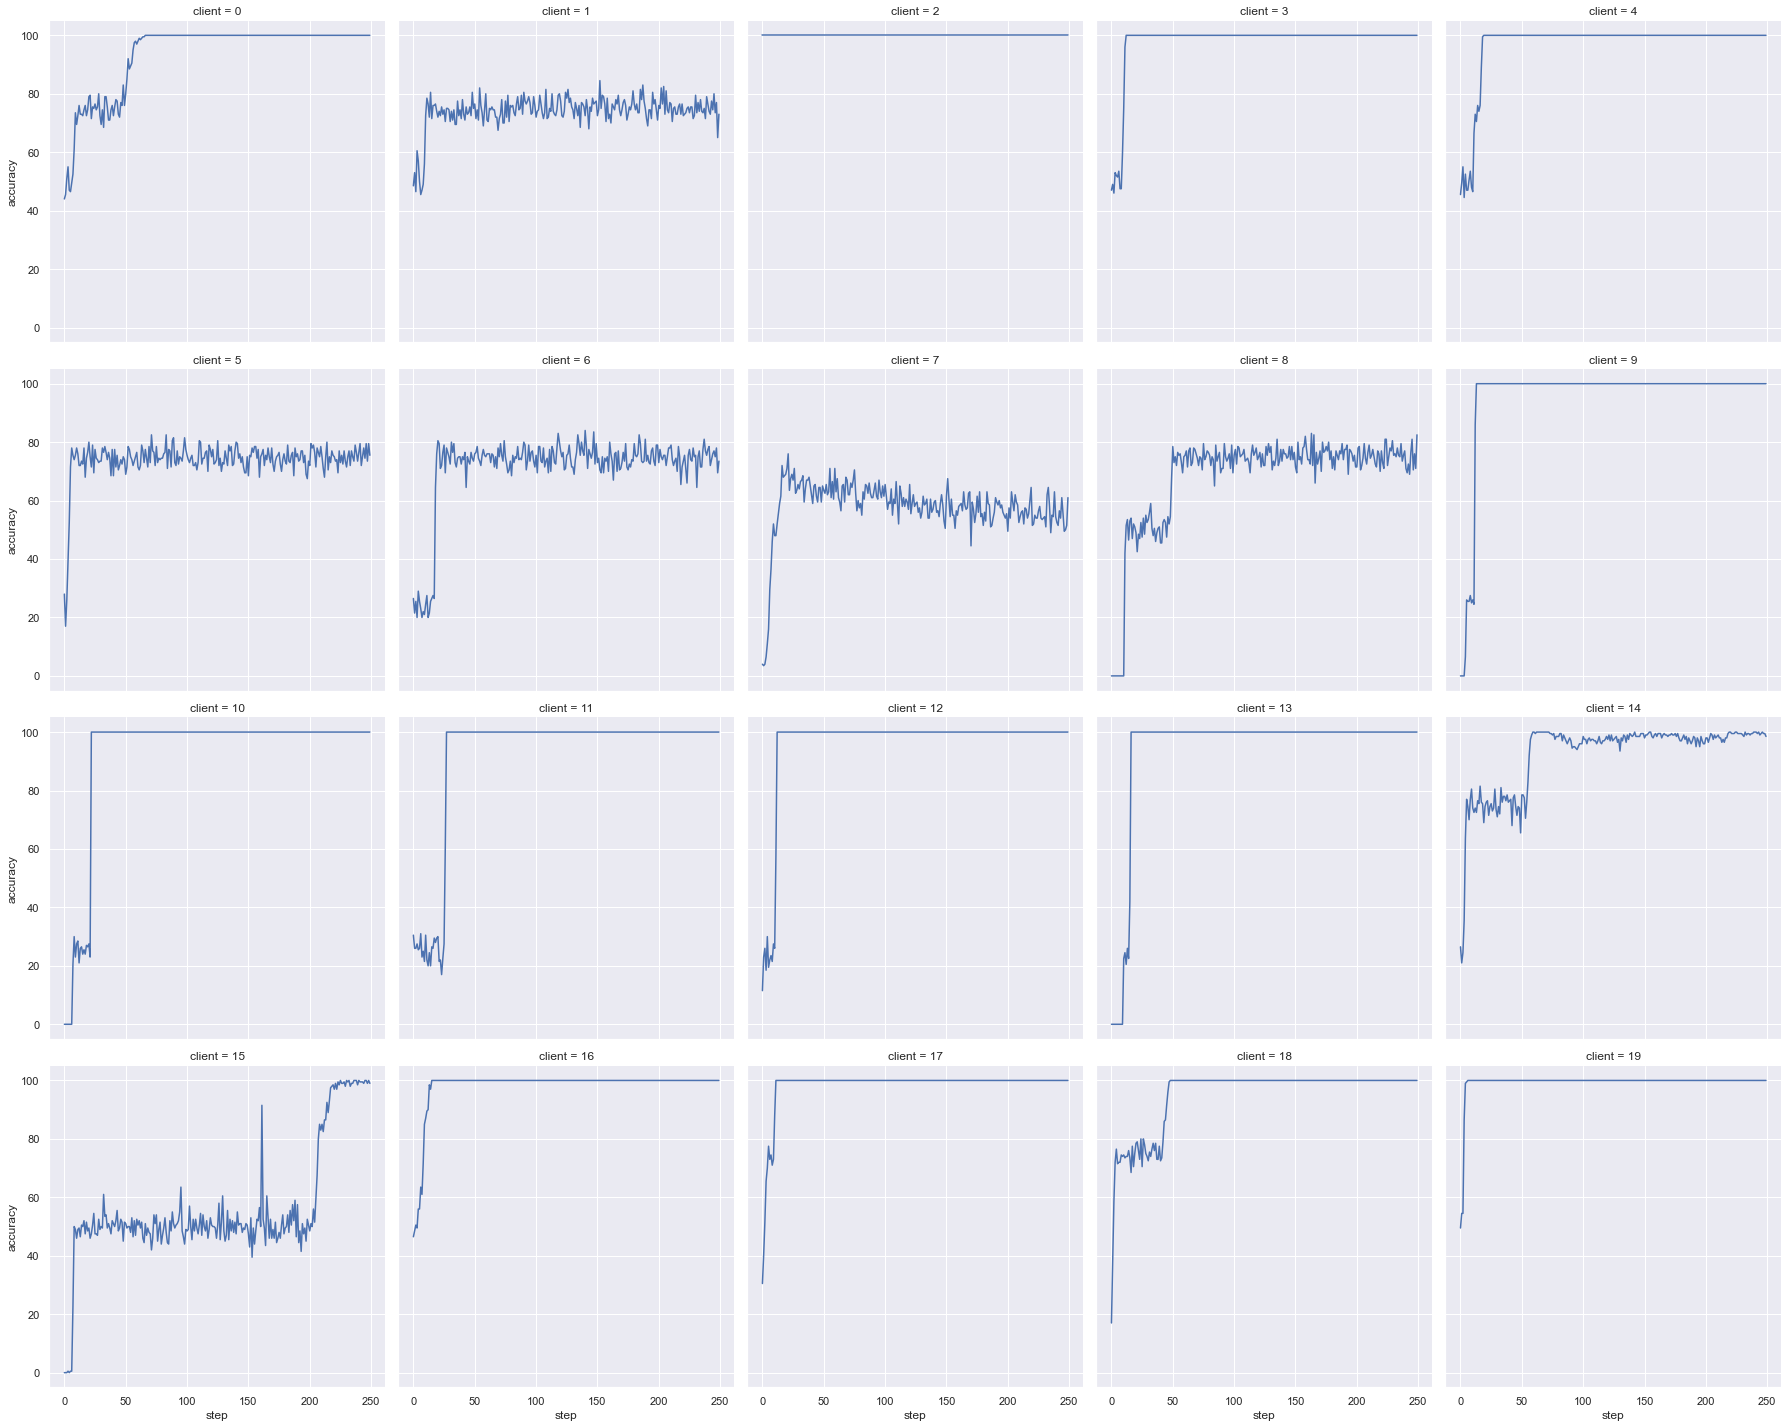

In [17]:
sns.relplot(x="step", y="accuracy", col="client", kind="line", data=runs, col_wrap=5)

In [38]:
model_predictions = pd.DataFrame(columns = ['client','feature_1', 'feature_2', 'label'])
X_test = torch.tensor(np.mgrid[-11:9:0.1, -10:12:0.1].T.reshape(-1,2)).float()
points = X_test.shape[0]

model_predictions['client'] = [i for i in range(n_clients) for _ in range(points)]
model_predictions['feature_1'] = list(X_test[:,0].numpy()) * n_clients
model_predictions['feature_2'] = list(X_test[:,1].numpy()) * n_clients

predictions = []
for model in final_models:
    predictions.extend(list(torch.argmax(model(X_test),dim=1).detach().numpy()))
    
model_predictions['label'] = predictions

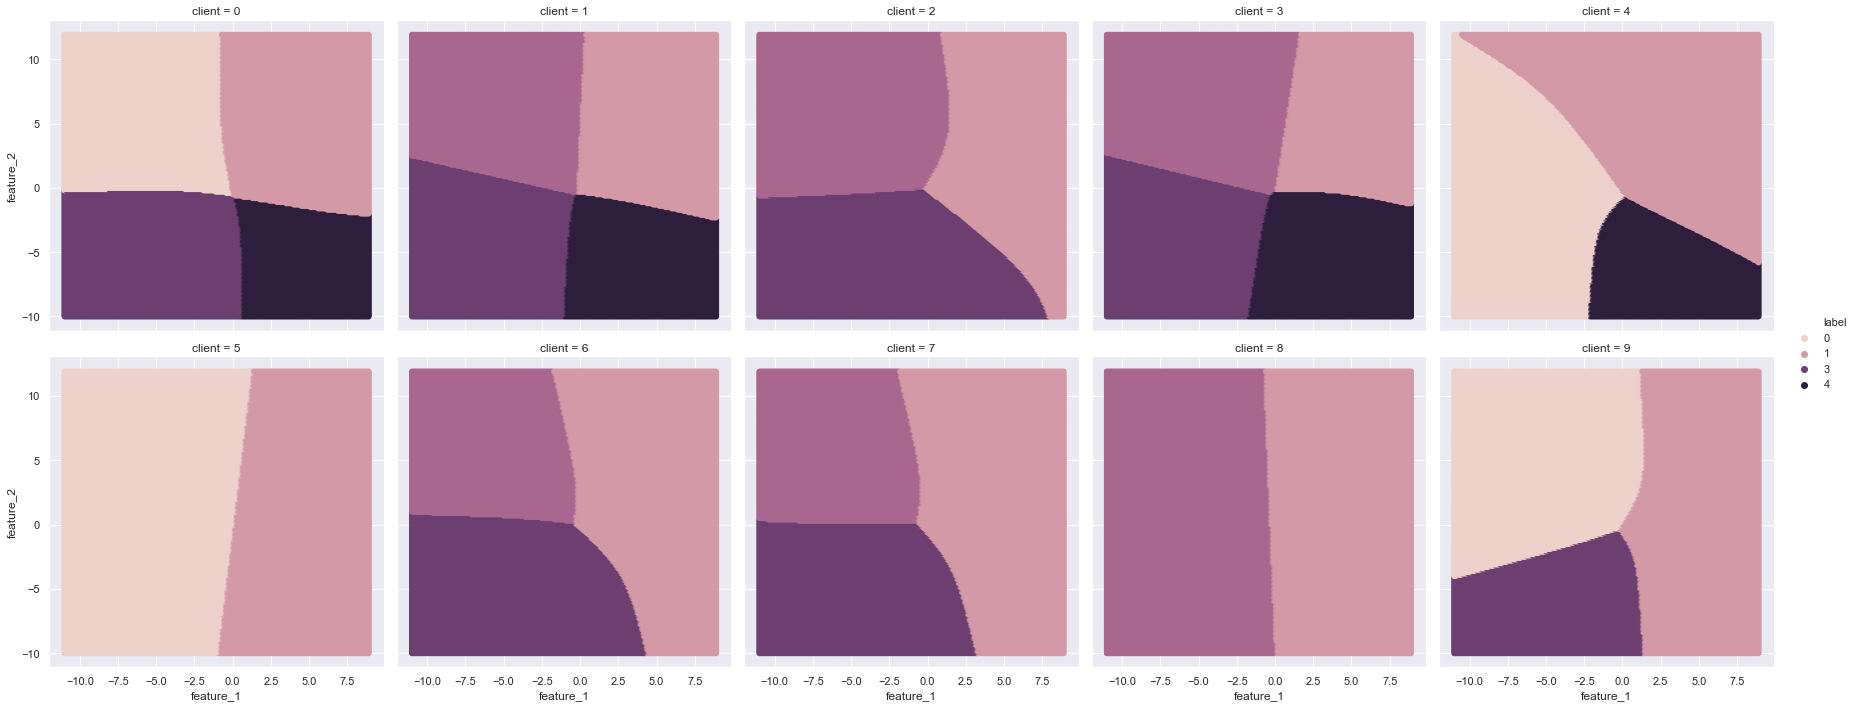

In [39]:
sns.relplot(x="feature_1", y="feature_2", hue="label", col="client", data=model_predictions, col_wrap=5, linewidth=0)

In [20]:
predictions = []
for model in final_models:
    predictions.append(list(model(X_test).detach().numpy()))

## Ensemble by summing across models then Argmaxing

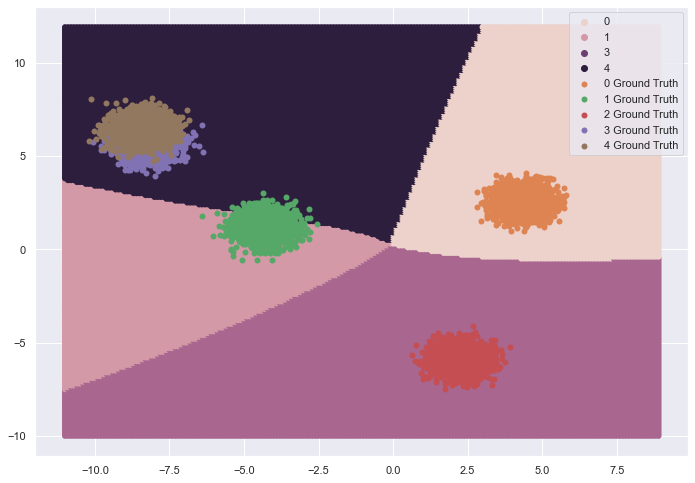

In [21]:
ensemble_y = np.argmax(np.sum(np.array(predictions),axis=0),axis=1)
sns.scatterplot(X_test[:,0], X_test[:, 1], hue=ensemble_y, linewidth=0)
for i in range(n_labels):
    idx = Y == i
    sns.scatterplot(X[idx,0], X[idx,1], label='{} Ground Truth'.format(i), linewidth=0)

# Ensembling by Voting

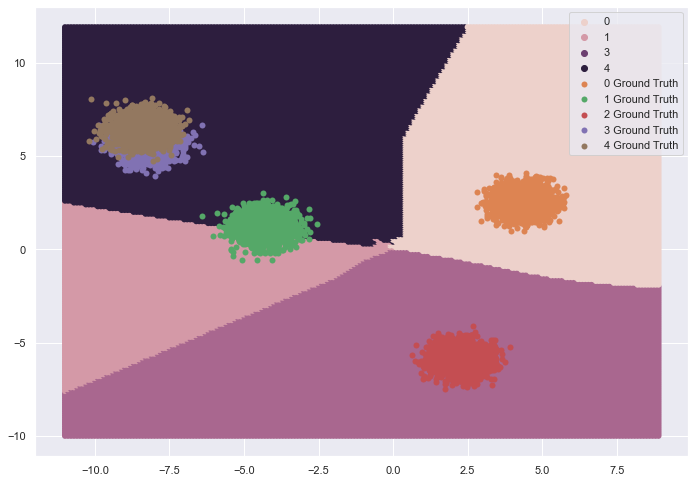

In [22]:
from scipy.stats import mode

vote_y = mode(np.argmax(np.array(predictions),axis=2),axis=0)[0].reshape(-1)
sns.scatterplot(X_test[:,0], X_test[:, 1], hue=vote_y, linewidth=0)
for i in range(n_labels):
    idx = Y == i
    sns.scatterplot(X[idx,0], X[idx,1], label='{} Ground Truth'.format(i), linewidth=0)

# Model Averaging

In [23]:
avg_model = sum(final_models, MLP().zero()) / n_clients

/Users/shashwatdalal/.local/share/virtualenvs/niid_test-Meyna6jB/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


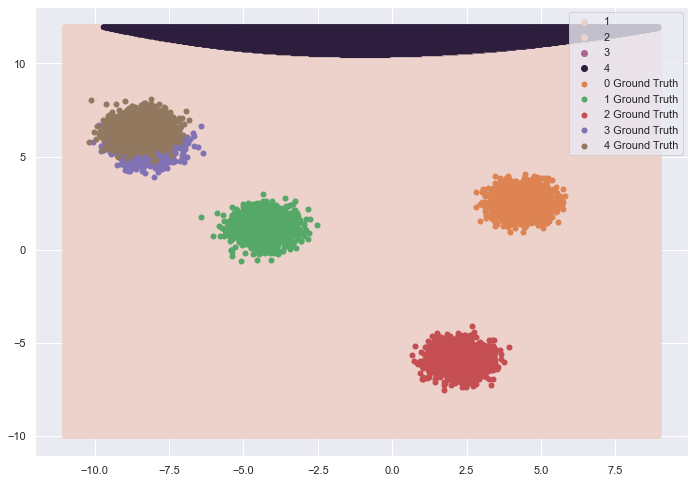

In [24]:
X_test = torch.tensor(np.mgrid[-11:9:0.05, -10:12:0.05].T.reshape(-1,2)).float()
predict = torch.argmax(avg_model(X_test), dim=1)

sns.scatterplot(X_test[:,0], X_test[:, 1], hue=predict.detach(), linewidth=0)
for i in range(n_labels):
    idx = Y == i
    sns.scatterplot(X[idx,0], X[idx,1], label='{} Ground Truth'.format(i), linewidth=0)

## FedAvg

In [166]:
loss_fn = nn.NLLLoss()
batch_size = 200
n_rounds = 50
n_steps = 10
lr = 0.01

In [167]:
zero_model = MLP().zero()
all_steps = [[[[] for _ in range(n_steps)] for _ in range(n_clients)] for _ in range(n_rounds)]
losses = [[] for _ in range(n_clients)]
acc = [[] for _ in range(n_clients)]
server_model_params = [[] for _ in range(n_rounds+1)]
model_per_round = []

server_model = MLP()
for name, param in server_model.named_parameters():
    server_model_params[0].extend(list(param.view(-1).detach().numpy()))
model_per_round.append(copy(server_model))
    
for round in range(n_rounds):
    client_models = []
    for client in range(n_clients):
        client_model = copy(server_model)
        optimizer = optim.Adam(lr=lr, params=client_model.parameters())
        for step in range(n_steps):
            optimizer.zero_grad()
            # log params
            for name, param in client_model.named_parameters():
                all_steps[round][client][step].extend(list(param.view(-1).detach().numpy()))
                
            # step of sgd
            batch_idx = np.random.randint(0, int(n_samples/ n_labels) * class_p_client, batch_size)
            predict = client_model(client_features[client,batch_idx])
            loss = loss_fn(predict, client_labels[client, batch_idx])
            loss.backward()
            optimizer.step()
            
            # log metrics
            losses[client].append(loss.item())
            acc[client].append(sum(client_labels[client, batch_idx] == torch.argmax(predict, dim=1)).item())
            
        client_models.append(client_model)
    server_model = sum(client_models, zero_model) / n_clients
    model_per_round.append(copy(server_model))
    for name, param in server_model.named_parameters():
        server_model_params[round+1].extend(list(param.view(-1).detach().numpy()))

In [168]:
step_matrix = torch.tensor(all_steps).reshape(-1, n_model_params)
server_models = torch.tensor(server_model_params).reshape(-1,n_model_params)

In [169]:
pca = PCA(n_components=2)

steps_pca = pca.fit_transform(step_matrix)
server_models_pca = pca.transform(server_models)

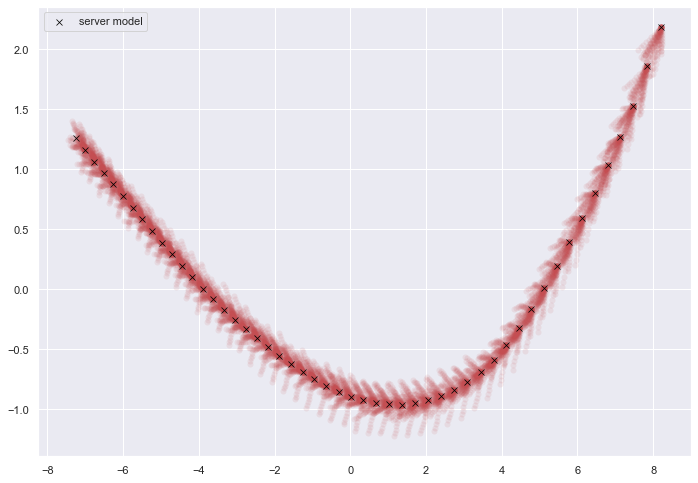

In [170]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.scatterplot(steps_pca[:,0],steps_pca[:, 1],color='r', linewidth=0, alpha=0.1)
sns.scatterplot(server_models_pca[:,0], server_models_pca[:,1], color='black', marker='x', label='server model')
plt.legend()
plt.show()

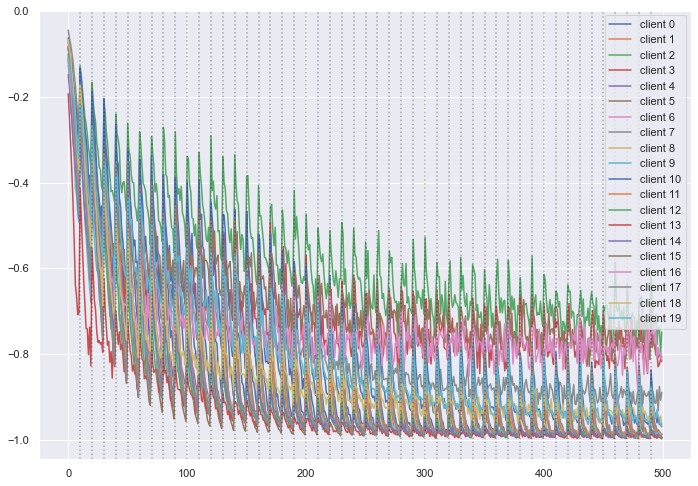

In [171]:
losses = np.array(losses)
for client in range(n_clients):
    plt.plot(losses[client], label='client {}'.format(client))
for r in range(1,n_rounds):
    plt.axvline(r*n_steps, color='black', linestyle=':', alpha=0.3)
plt.legend()

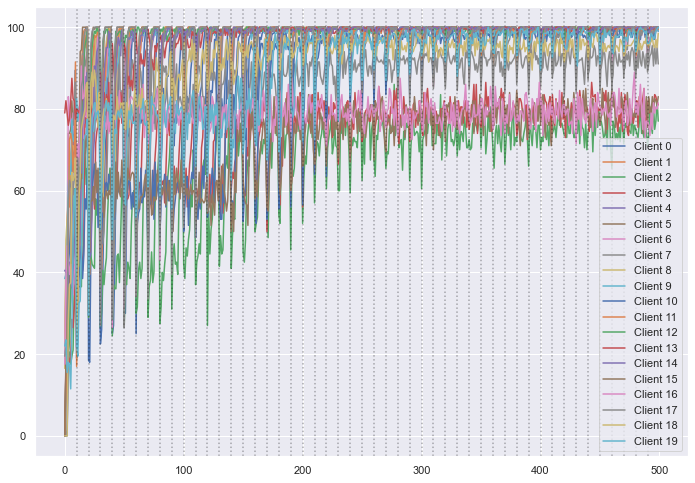

In [172]:
acc = (np.array(acc) / batch_size) * 100
for client in range(n_clients):
    plt.plot(acc[client], label="Client {}".format(client))
for r in range(1,n_rounds):
    plt.axvline(r*n_steps, color='black', linestyle=':', alpha=0.3)
plt.legend()

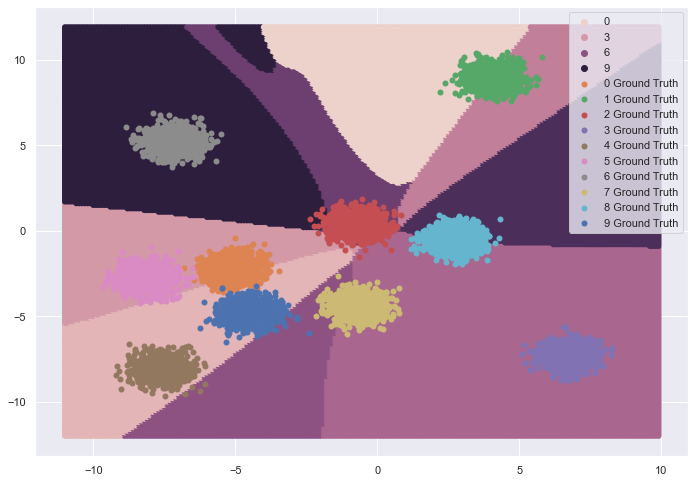

In [173]:
X_test = torch.tensor(np.mgrid[-11:10:0.1, -12:12:0.1].T.reshape(-1,2)).float()

# turn on eval mode to turn off drop-off effect
server_model.eval()
predict = torch.argmax(server_model(X_test), dim=1)

sns.scatterplot(X_test[:,0], X_test[:, 1], hue=predict.detach(), linewidth=0)
for i in range(n_labels):
    idx = Y == i
    sns.scatterplot(X[idx,0], X[idx,1], label='{} Ground Truth'.format(i), linewidth=0)